## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization,\
 DepthwiseConv2D, LayerNormalization
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, SGD

import matplotlib as mpl
import sys
import time
import csv
!pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 19.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

your_workspace = 'Ming/Public_Data' #<your_workspace>
work_dir = '/content/gdrive/My Drive/Colab Notebooks/' + <your_workspace>
import os
os.chdir(work_dir)
!pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/Ming/Public_Data


In [23]:
################### Data mat ####################
# Load data (Binary channel realizations) generated from snesim

fname = 'continuous' # 'discontinuous'

with np.load('./Data/'+ fname + "_channel_reals.npz") as npzfile:
  realizations = npzfile['realizations']

NR=realizations.shape[0]

X_raw = realizations.reshape((NR,-1))

## Data Rescale
may need to split data to binary at mean value or rescale data to [-1,1]


 

In [24]:
X_raw_min = np.min(X_raw,axis=1)
X_raw_max = np.max(X_raw,axis=1)
X_range =  X_raw_max-X_raw_min
X_remove_mean = (X_raw - X_raw_min[:,None]) / X_range[:,None] *2.0 -1.0

X_train = np.reshape(X_remove_mean, (1000,128,128))

Text(0.5, 1.0, 'True field')

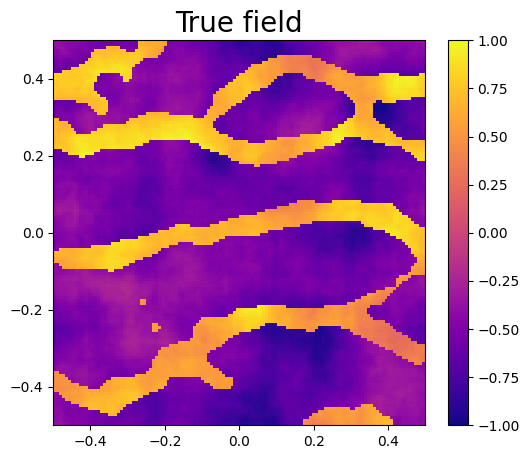

In [25]:
############### define domain with (0,0) at center ######
Lox, Loy = 1, 1
nx, ny = 128, 128
dx, dy = Lox/nx, Loy/ny
x = np.arange((-Lox/2+dx/2),(Lox/2),dx)
y = np.arange((-Lox/2+dx/2),(Lox/2),dy)

Xm, Ym = np.meshgrid(x,y)

fig, ax = plt.subplots(1,1,figsize=(6,5))
im = ax.pcolormesh(Xm,Ym,np.reshape(X_train[20], (128, 128)),cmap='plasma')
fig.colorbar(im, ax=ax)
ax.set_title('True field',fontsize=20)

## DC-GAN
Deconvolution Generative Adversarial Network

In [26]:
class ConvGAN():
  def __init__(self):
    self.img_rows = 128
    self.img_cols = 128
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 16
    boundaries = [2000, 4000]
    values = [1e-4, 5e-5, 1e-5]
    learning_rate_fn = PiecewiseConstantDecay(boundaries, values)

    # Later, whenever we perform an optimization step, we pass in the step.
    step = tf.Variable(0, trainable=False)
    learning_rate = learning_rate_fn(step)

    optimizer = Adam(learning_rate, beta_1 = 0.5)
    optimizer1 = Adam(learning_rate, beta_1 = 0.5)

    # Build and compile the discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

    # Build the generator
    self.generator = self.build_generator()

    # The generator takes noise as input and generates imgs
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)

    # For the combined model we will only train the generator
    self.discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    validity = self.discriminator(img)

    # The combined model  (stacked generator and discriminator)
    # Trains the generator to fool the discriminator
    self.combined = Model(z, validity)
    self.combined.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False)
                    , optimizer=optimizer1)

    self.dis_log = []
    self.dis_acc = []
    self.gen_log = []

  def build_generator(self):
    hidden_act = None
    kernel_size = 5
    generator_inputs = Input(shape=(self.latent_dim,))
    x = Dense((8*8*32))(generator_inputs)
    x = Reshape((8, 8, 32))(x)

    x = Conv2DTranspose(64, kernel_size, activation=hidden_act, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2DTranspose(128, kernel_size, activation=hidden_act, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D(size=(2,2))(x)

    img = Conv2DTranspose(1, kernel_size=5, activation="tanh", strides=1, padding="same")(x)
    
    generator = Model(generator_inputs, img, name='Generator')

    generator.summary()

    return generator

  def save_logs(self, loss_D, loss_G):
    self.dis_log.append(loss_D[0])
    self.dis_acc.append(loss_D[1])
    self.gen_log.append(loss_G)

  def build_discriminator(self):
    hidden_act = None
    kernel_size = 5
    discriminator_inputs =  Input(shape=self.img_shape)
    x = Conv2D(64, kernel_size, strides=2, activation=hidden_act, padding="same")(discriminator_inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, kernel_size, strides=2, activation=hidden_act, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, kernel_size, strides=2, activation=hidden_act, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    discriminator = Model(discriminator_inputs, outputs, name='Discriminator')
    discriminator.summary()
    return discriminator

  def train(self, X_train, epochs, batch_size=128, sample_interval=50):
    # Load the dataset
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size,))
    fake = np.zeros((batch_size,))
    start_time = time.time()

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

        # Generate a batch of new images
        gen_imgs = self.generator.predict(noise,verbose=0)

        # Train the discriminator
        d_loss_real = self.discriminator.train_on_batch(imgs, valid)
        d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = self.combined.train_on_batch(noise, valid)
        self.save_logs(d_loss, g_loss)

        # Plot the progress
        if epoch % 100 == 0:
          colapsed_time = time.time() - start_time
          start_time = time.time()
          print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f] [train time: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss, colapsed_time))

        # If at save interval => save generated image samples
        if epoch < 1000 and epoch % 100 == 0 or \
           epoch % sample_interval == 0:
            self.sample_images(epoch)

  def sample_images(self, epoch):
    r, c = 3, 3
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))

    gen_imgs = self.generator.predict(noise,verbose=0)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='plasma')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(f"{image_dir}/Channel_Gaussian_epoch_%d_%dx%d.png" % (epoch,r,c)) 

    plt.close()



## Model Train

In [34]:
image_dir = "./DCGAN_images"

model_dir = "./DCGAN_model"
try:
  os.makedirs(image_dir)
except:
  FileExistsError

try:
  os.makedirs(model_dir)
except:
  FileExistsError
 


In [35]:
conv_gan = ConvGAN()
conv_gan.train(X_train, epochs=5000, batch_size=100, sample_interval=1000)


Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        1664      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 128)       409728    
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 16, 16, 128)     

KeyboardInterrupt: ignored

In [ ]:
conv_gan.discriminator.save(model_dir+'/DCGAN_discriminator'+fname)
conv_gan.generator.save(model_dir+'/DCGAN_generator'+fname)

## Make prediction

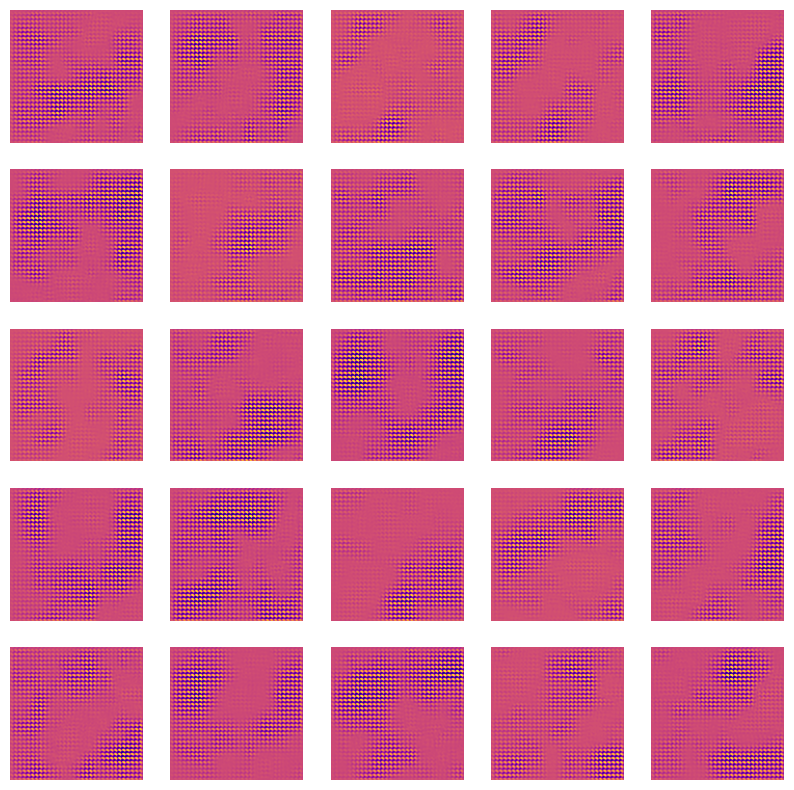

In [37]:
r, c = 5, 5

noise = np.random.normal(0, 1, (r * c, conv_gan.latent_dim))

gen_imgs = conv_gan.generator.predict(noise, verbose = 0)

fig, axs = plt.subplots(r, c,figsize=(10,10))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='plasma')
        axs[i,j].axis('off')
        cnt += 1


## Plot results

Text(0.5, 1.0, 'generated from GAN')

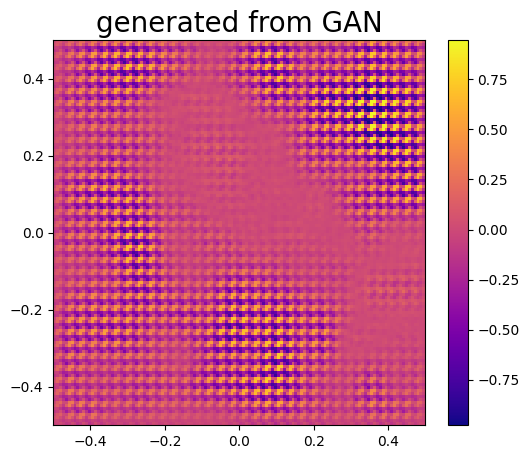

In [38]:
fid=20

fig, ax = plt.subplots(1,1,figsize=(6,5))
im = plt.pcolormesh(Xm,Ym,gen_imgs[fid, :,:,0], cmap='plasma')
fig.colorbar(im, ax=ax)
ax.set_title('generated from GAN',fontsize=20)